<a href="https://colab.research.google.com/github/2series/self_analysis/blob/master/creditCardDefault_09_05_220.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Default Prediction
## Intro to h2o's GLM using lending club loan data


In [2]:
# dependencies
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [3]:
!pip install h2o

In [4]:
import h2o # h2o python module
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='16G') # starting + connecting to h2o cluster

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm_59j9pa
  JVM stdout: /tmp/tmpm_59j9pa/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpm_59j9pa/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,"14 days, 8 hours and 37 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_8edepb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


## Data in H2O
###Data Import

The most common function for loading data into an H2O cluster is to use the import_file on files that are visible to the cluster using either a server-side file system path, HDFS path, S3, or a URL. If the data files are local to the Python client, the upload_file function uploads files based upon a local path to the H2O cluster

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on Kaggle. This data consists of 15 variables:

+ **loan_amnt**: Requested loan amount (US dollars)
+ **term**: Loan term length (months)
+ **int_rate**: Recommended interest rate
+ **emp_length**: Employment length (years)
+ **home_ownership**: Housing status
+ **annual_inc**: Annual income (US dollars)
+ **purpose**: Purpose for the loan
+ **addr_state**: State of residence
+ **dti**: Debt to income ratio
+ **delinq_2yrs**: Number of delinquencies in the past 2 years
+ **revol_util**: Percent of revolving credit line utilized
+ **total_acc**: Number of active accounts
+ **bad_loan**: Bad loan indicator
+ **longest_credit_length**: Age of oldest active account
+ **verification_status**: Income verification status

In [5]:
# load data
train_path = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'

train = h2o.import_file(train_path, destination_frame='loan_train')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
train.head()

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
5000,36 months,10.65,10,RENT,24000,credit_card,AZ,27.65,0,83.7,9,0,26,verified
2500,60 months,15.27,0,RENT,30000,car,GA,1,0,9.4,4,1,12,verified
2400,36 months,15.96,10,RENT,12252,small_business,IL,8.72,0,98.5,10,0,10,not verified
10000,36 months,13.49,10,RENT,49200,other,CA,20,0,21,37,0,15,verified
5000,36 months,7.9,3,RENT,36000,wedding,AZ,11.2,0,28.3,12,0,7,verified
3000,36 months,18.64,9,RENT,48000,car,CA,5.35,0,87.5,4,0,4,verified
5600,60 months,21.28,4,OWN,40000,small_business,CA,5.55,0,32.6,13,1,7,verified
5375,60 months,12.69,0,RENT,15000,other,TX,18.08,0,36.5,3,1,7,verified
6500,60 months,14.65,5,OWN,72000,debt_consolidation,AZ,16.12,0,20.6,23,0,13,not verified
12000,36 months,12.69,10,OWN,75000,debt_consolidation,CA,10.78,0,67.1,34,0,22,verified


In [7]:
train.shape

(163987, 15)

In [8]:
# data object
type(train)

h2o.frame.H2OFrame

In [0]:
# help on the class H2OFrame in module h2o.frame
#help(h2o.H2OFrame)

In [10]:
# feature names
train.col_names

['loan_amnt',
 'term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'bad_loan',
 'longest_credit_length',
 'verification_status']

In [11]:
# features and data types
train.types

{'addr_state': 'enum',
 'annual_inc': 'real',
 'bad_loan': 'int',
 'delinq_2yrs': 'int',
 'dti': 'real',
 'emp_length': 'int',
 'home_ownership': 'enum',
 'int_rate': 'real',
 'loan_amnt': 'int',
 'longest_credit_length': 'int',
 'purpose': 'enum',
 'revol_util': 'real',
 'term': 'enum',
 'total_acc': 'int',
 'verification_status': 'enum'}

## Response variable 'bad_loan' is intergy dtype

In [12]:
print(train.frame_id)

loan_train


In [0]:
train['bad_loan'] = train['bad_loan'].asfactor()

In [14]:
print(train.frame_id)

py_2_sid_9199


## EDA of response variable

### A Quick Look at the Target Variable
We will begin our exploration with a quick look at the frequency of **bad_loan** status in the data using H2OFrame's table method. Since the table method returns an H2OFrame, it is converted to a pandas DataFrame using the as_data_frame method. The bad_loan rate for customers in this dataset is roughly 18%

In [15]:
tbl = train["bad_loan"].table()
tbl = tbl.as_data_frame()

print(tbl)
print("\nFraction of bad_loan = {:0.4f}".format(tbl[tbl["bad_loan"] == 1]["Count"].values[0] / tbl["Count"].sum()))

   bad_loan   Count
0         0  133971
1         1   30016

Fraction of bad_loan = 0.1830


# O = good_loan, 1 = bad_loan

### A Quick Look at the Predictor Variables
In preparation for our modeling bad_loan, we can turn to H2OFrame's describe method to provide summary statistics for each of the features in the dataset, which includes minimums, maximums, means, and standard deviations

Given the nature of this data, it will also be useful to explore the skewness and shape of the numeric data, columns_by_type("numeric"), using H2OFrame's skewness and kurtosis methods. These aspects of the data are shown graphically using H2OFrame's hist method to produce histograms for numeric columns

As the summaries below show, most of the numeric features contain skewed data that we will address during **feature engineering**


In [16]:
train.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456343,,13.715904065566196,5.684352932995332,,71915.67051974912,,,15.881530121290096,0.2273570060625282,54.07917280242263,24.579733834274666,,14.854273655448347,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.55618873466,,4.391939870545791,3.6106637311002343,,59070.915654918215,,,7.587668224192543,0.6941679229284188,25.285366766770505,11.685190365910671,,6.947732922546691,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


## Explore shape and skewness of numeric data columns

In [17]:
# feature skewness
{train.col_names[int(j)] : train[int(j)].skewness(na_rm=True)[0] for j in train.columns_by_type("numeric")}

{'annual_inc': 35.49017527656552,
 'delinq_2yrs': 5.9610641741129875,
 'dti': 0.1821584006068137,
 'emp_length': -0.10544152153509748,
 'int_rate': 0.32786188664582,
 'loan_amnt': 0.8753344731629368,
 'longest_credit_length': 1.1320402013275574,
 'revol_util': -0.24909373161407677,
 'total_acc': 0.7672568687389283}

In [18]:
# feature kurtosis
{train.col_names[int(j)] : train[int(j)].kurtosis(na_rm=True)[0] for j in train.columns_by_type("numeric")}

{'annual_inc': 3270.7235742066455,
 'delinq_2yrs': 75.67871449256873,
 'dti': 2.476608894474025,
 'emp_length': 1.5971274246737552,
 'int_rate': 2.679198621886723,
 'loan_amnt': 3.2288978583663206,
 'longest_credit_length': 4.9621647223568734,
 'revol_util': 2.197947871921963,
 'total_acc': 3.6270448687188783}

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

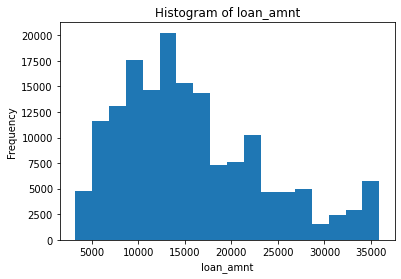

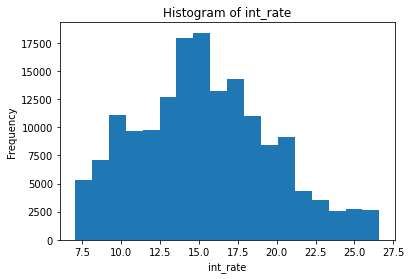

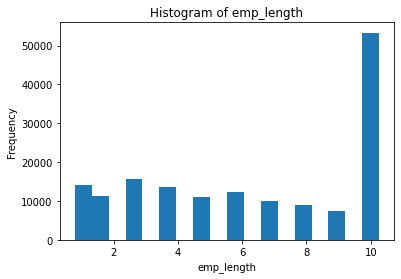

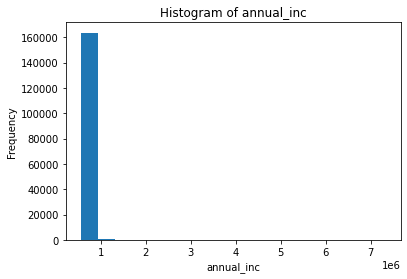

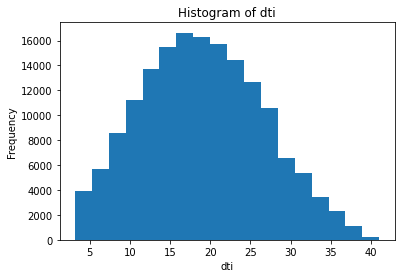

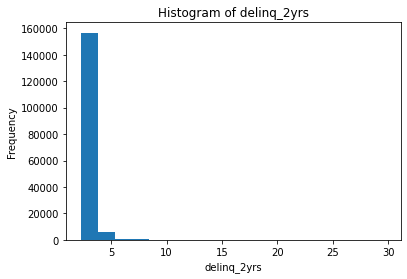

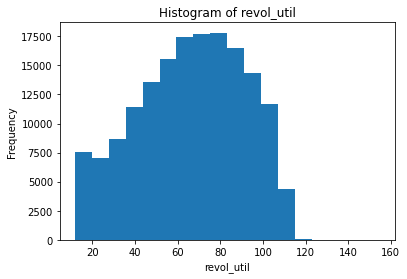

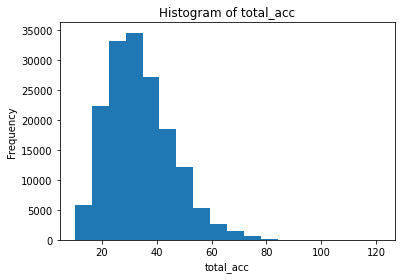

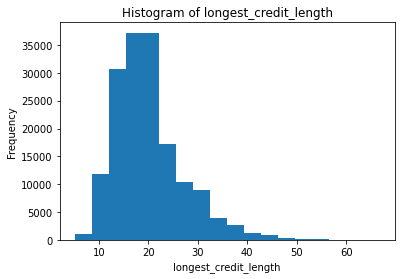

In [20]:
for j in train.columns_by_type('numeric'):
  train[int(j)].hist()
plt.show()  

## Features Engineering

Since the goal of this analysis is to **predict credit card default**, we will create a string, y, for the response variable, "bad_loan", and a list of column names for the original set of predictors, x_orig

The original set of predictors should not include **interest rate** since they were set based upon a risk assessment that the loan would be bad

The goal of this section is to improve upon these **predictors** through a number of feature engineering steps. In particular, we will perform three feature engineering tasks:

i.e. separate, convert, create

1. **Separating Typical from Extreme Loan Amount**
2. **Converting Term to a 0/1 Indicator**
3. **Creating Missing Value Indicator for Employment Length**
4. **Combining Categories in Home Ownership**
5. **Separating Typical from Extreme Annual Income**
6. **Target Encoding for Loan Purpose**
7. **Target Encoding for State of Residence**
8. **Separating Typical from Extreme Debt to Income Ratio**
9. **Separating Typical from Extreme Number of Delinquencies in the Past 2 Years**
10. **Separating Typical from Extreme Revolving Credit Line Utilized**
11. **Separating Typical from Extreme Number of Credit Lines**
12. **Separating Typical from Extreme Longest Credit Length**
13. **Converting Income Verification Status to a 0/1 Indicator**

In [21]:
y = 'bad_loan' # create str y for target variable
x_orig = train.col_names # list of original feature names
x_orig.remove(y) # target variable remove from original set
x_orig.remove('int_rate') # feature remove, based upon risk assessment from original set

x_train = x_orig.copy()
x_train

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

### CV and target encoding

This analysis will use **cross-validated mean target encoding of the categorical predictors** as OHE can lead to overfitting of infrequent categories

To achieve this goal, we will first create soft partitions using H2OFrame's kfold_column function, then calculate summary statistics using H2O's group_by function, and finally join these engineered features using H2OFrame's merge

In [0]:
cv_nfolds = 5
cv_seed = 987

In [0]:
train['cv_fold'] = train.kfold_column(n_folds=cv_nfolds, seed=cv_seed)

In [24]:
train['cv_fold'].table()

cv_fold,Count
0,32818
1,32810
2,33045
3,32570
4,32744


In [0]:
import numpy as np
import pandas as pd

In [0]:
def logit(p):
  return np.log(p) - np.log(1 - p)

In [0]:
def mean_target(data, x, y='bad_loan'):
  grouped_data = data[[x, y]].group_by([x])
  stats = grouped_data.count(na='ignore').mean(na='ignore')
  return stats.get_frame().as_data_frame()

In [0]:
def mean_target_encoding(data, x, y='bad_loan', fold_column='cv_fold', prior_mean=0.183, prior_count=1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na='ignore').count(na='ignore')
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = 'te_{}'.format(x)
        sum_y = 'sum_{}'.format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, 'nrow']]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats['nrow'] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))


### 1. Separating Typical from Extreme Loan Amount

In [29]:
train['loan_amnt'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [0]:
breaks = np.linspace(0, 35000, 8).tolist()
train['loan_amnt_cat'] = train['loan_amnt'].cut(breaks=breaks)

In [0]:
df = mean_target(train, 'loan_amnt_cat')

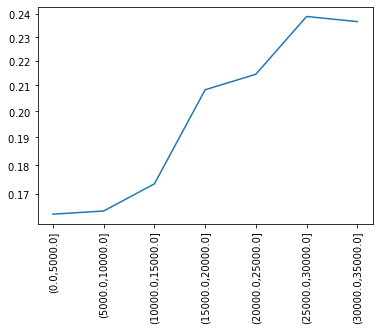

In [32]:
plt.xticks(rotation=90)
plt.yscale('logit')
plt.plot(df['loan_amnt_cat'], df['mean_bad_loan'])
plt.show()

After binning loan_amt using H2OFrame's cut function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \$5,000 to \$30,000 and is relatively flat below \$5,000 and above \$30,000

To reflect this finding in the modeling, we will replace the original loan_amnt measure with two derived measures:

In [33]:
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",25785,0.163234
1,"(5000.0,10000.0]",50384,0.164278
2,"(10000.0,15000.0]",35552,0.173436
3,"(15000.0,20000.0]",24659,0.208281
4,"(20000.0,25000.0]",14447,0.214508
5,"(25000.0,30000.0]",6913,0.238825
6,"(30000.0,35000.0]",6247,0.236594


In [0]:
x_train.remove('loan_amnt')
x_train.append('loan_amnt_core')
x_train.append('loan_amnt_delta')

train['loan_amnt_core'] = h2o.H2OFrame.ifelse(train['loan_amnt'] <= 5000, 5000, train['loan_amnt'])
train['loan_amnt_core'] = h2o.H2OFrame.ifelse(train['loan_amnt_core'] <= 30000, train['loan_amnt_core'], 30000)

train['loan_amnt_delta'] = train["loan_amnt"] - train['loan_amnt_core']

### 2. Converting Term to a 0/1 Indicator

In [35]:
train['term'].table()

term,Count
36 months,129950
60 months,34037


Given that term of the loans are either 3 or 5 years, we will create a simplifed term_36month binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years

In [0]:
x_train.remove('term')
x_train.append('term_60months')

train['term_60months'] = train['term'] == '60 months'

In [37]:
train['term_60months'].table()

term_60months,Count
0,129950
1,34037


### 3. Creating Missing Value Indicator for Employment Length

In [38]:
train['emp_length'].summary()

,emp_length
type,int
mins,0.0
mean,5.684352932995332
maxs,10.0
sigma,3.6106637311002343
zeros,14248
missing,5804
0,10.0
1,0.0
2,10.0


The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively

Interestingly, there doesn't appear to be any differences in bad loans across employment lengths

In [0]:
x_train.append('emp_length_missing')

train['emp_length_missing'] = train['emp_length'] == None

In [40]:
mean_target_encoding(train, 'emp_length_missing')

Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.51627
1,0,-1.04832
0,1,-1.5119
1,1,-1.00873
0,2,-1.52094
1,2,-1.03431
0,3,-1.51924
1,3,-1.02358
0,4,-1.50977
1,4,-1.04019


In [0]:
df = mean_target(train, 'emp_length')

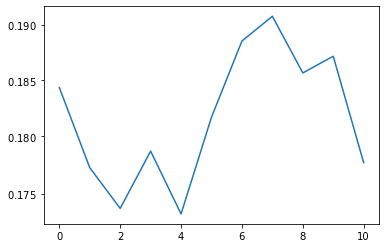

In [42]:
plt.yscale('logit')
plt.plot(df['emp_length'], df['mean_bad_loan'])
plt.show()

In [43]:
df

,emp_length,nrow,mean_bad_loan
0,NaN,0,0.262922
1,0.0,14248,0.184307
2,1.0,11414,0.177238
3,2.0,15766,0.173728
4,3.0,13611,0.178679
5,4.0,11024,0.173258
6,5.0,12347,0.181664
7,6.0,10000,0.188500
8,7.0,9079,0.190770
9,8.0,7424,0.185614


### 4. Combining Categories in Home Ownership

In [44]:
mean_target(train, 'home_ownership')

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,79714,0.164137
2,NONE,30,0.233333
3,OTHER,156,0.224359
4,OWN,13560,0.188348
5,RENT,70526,0.203273


Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT 

The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category

This new home_ownership_3cat variable will have values in {MORTGAGE, OTHER, OWN}

In [0]:
lvls = ['OTHER', 'MORTGAGE', 'OTHER', 'OTHER', 'OWN', 'OTHER'] # levels of home_ownership
train['home_ownership_3cat'] = train['home_ownership'].set_levels(lvls).ascharacter().asfactor()

In [46]:
train[['home_ownership', 'home_ownership_3cat']].table()

home_ownership,home_ownership_3cat,Counts
ANY,OTHER,1
MORTGAGE,MORTGAGE,79714
NONE,OTHER,30
OTHER,OTHER,156
OWN,OWN,13560
RENT,OTHER,70526


In [47]:
mean_target(train, 'home_ownership_3cat')

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,79714,0.164137
1,OTHER,70713,0.203329
2,OWN,13560,0.188348


In [0]:
x_train.remove('home_ownership')
x_train.append('home_ownership_3cat')

### 5. Separating Typical from Extreme Annual Income

In [49]:
train['annual_inc'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,1896
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,145000
1,7.14178e+06


In [0]:
breaks = np.linspace(0, 150000, 31).tolist()
train['annual_inc_cat'] = train['annual_inc'].cut(breaks=breaks)

In [0]:
df = mean_target(train, 'annual_inc_cat')

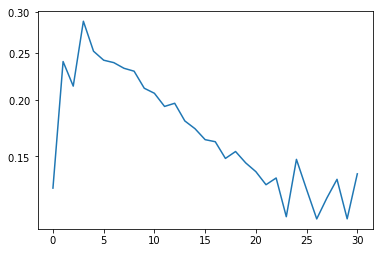

In [52]:
plt.yscale('logit')
plt.plot(df['annual_inc_cat'].index, df['mean_bad_loan'])
plt.show()

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \$10,000 to \$105,000 and is relatively flat above \$105,000

To reflect this finding in the modeling, we will replace the original annual_inc measure with two derived measures

In [53]:
df[0:6]

,annual_inc_cat,nrow,mean_bad_loan
0,NaN,0,0.126695
1,"(0.0,5000.0]",25,0.240000
2,"(5000.0,10000.0]",192,0.213542
3,"(10000.0,15000.0]",868,0.288018
4,"(15000.0,20000.0]",1847,0.251760
5,"(20000.0,25000.0]",3975,0.241509


In [54]:
df[20:31]

,annual_inc_cat,nrow,mean_bad_loan
20,"(95000.0,100000.0]",5473,0.138315
21,"(100000.0,105000.0]",2860,0.129021
22,"(105000.0,110000.0]",3275,0.133740
23,"(110000.0,115000.0]",1908,0.108491
24,"(115000.0,120000.0]",3009,0.147557
25,"(120000.0,125000.0]",1741,0.125790
26,"(125000.0,130000.0]",1642,0.107186
27,"(130000.0,135000.0]",974,0.120123
28,"(135000.0,140000.0]",1235,0.132794
29,"(140000.0,145000.0]",746,0.107239


In [0]:
x_train.remove('annual_inc')
x_train.append('annual_inc_core')
x_train.append('annual_inc_delta')

train['annual_inc_core'] = h2o.H2OFrame.ifelse(train['annual_inc'] <= 10000, 10000, train['annual_inc'])
train['annual_inc_core'] = h2o.H2OFrame.ifelse(train['annual_inc_core'] <= 105000,
                                               train['annual_inc_core'], 105000)

train['annual_inc_delta'] = train['annual_inc'] - train['annual_inc_core']

### 6. Target Encoding for Loan Purpose

In [56]:
tbl = train['purpose'].table().as_data_frame()
tbl['Percent'] = np.round((100 * tbl['Count'] / train.nrows), 2)
tbl = tbl.sort_values(by='Count', ascending=0)
tbl = tbl.reset_index(drop=True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  93261    56.87
1          credit_card  30792    18.78
2                other  10492     6.40
3     home_improvement   9872     6.02
4       major_purchase   4686     2.86
5       small_business   3841     2.34
6                  car   2842     1.73
7              medical   2029     1.24
8              wedding   1751     1.07
9               moving   1464     0.89
10               house   1245     0.76
11            vacation   1096     0.67
12         educational    418     0.25
13    renewable_energy    198     0.12


Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting of the later group

In [57]:
mean_target(train, 'purpose')

,purpose,nrow,mean_bad_loan
0,car,2842,0.125968
1,credit_card,30792,0.157281
2,debt_consolidation,93261,0.189479
3,educational,418,0.210526
4,home_improvement,9872,0.155895
5,house,1245,0.182329
6,major_purchase,4686,0.137217
7,medical,2029,0.203056
8,moving,1464,0.207650
9,other,10492,0.214354


In [58]:
te_purpose = mean_target_encoding(train, 'purpose')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train = train.merge(te_purpose, all_x=True)

In [0]:
x_train.remove('purpose')
x_train.append('te_purpose')

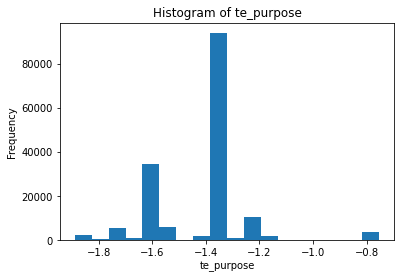

In [61]:
train['te_purpose'].hist()

### 7. Target Encoding for State of Residence
We will also use a mean target encoding for state of residence for a reason similar to that for purpose


In [62]:
tbl = train['addr_state'].table().as_data_frame()
tbl['Percent'] = np.round((100 * tbl['Count'] / train.nrows), 2)
tbl = tbl.sort_values(by='Count', ascending=0)
tbl = tbl.reset_index(drop=True)
print(tbl)

   addr_state  Count  Percent
0          CA  28702    17.50
1          NY  14285     8.71
2          TX  12128     7.40
3          FL  11396     6.95
4          NJ   6457     3.94
5          IL   6099     3.72
6          PA   5427     3.31
7          VA   5282     3.22
8          GA   5189     3.16
9          OH   4896     2.99
10         NC   4393     2.68
11         MA   4164     2.54
12         AZ   3941     2.40
13         MD   3890     2.37
14         WA   3823     2.33
15         MI   3762     2.29
16         CO   3531     2.15
17         MN   2771     1.69
18         MO   2627     1.60
19         CT   2563     1.56
20         NV   2387     1.46
21         OR   2149     1.31
22         WI   1980     1.21
23         AL   1965     1.20
24         LA   1885     1.15
25         SC   1826     1.11
26         KY   1477     0.90
27         IN   1463     0.89
28         UT   1389     0.85
29         KS   1335     0.81
30         OK   1331     0.81
31         TN   1327     0.81
32        

In [0]:
df = mean_target(train, 'addr_state')

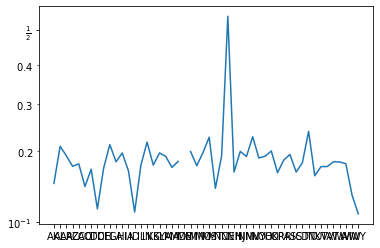

In [64]:
plt.yscale('logit')
plt.plot(df['addr_state'], df['mean_bad_loan'])
plt.show()

In [65]:
te_addr_state = mean_target_encoding(train, 'addr_state', prior_count=30)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train = train.merge(te_addr_state, all_x=True)

In [0]:
x_train.remove('addr_state')
x_train.append('te_addr_state')

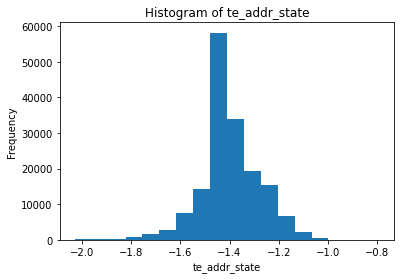

In [68]:
train['te_addr_state'].hist()

### 8. Separating Typical from Extreme Debt to Income Ratio

In [69]:
train['dti'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.79
0.25,10.23
0.5,15.62
0.75,21.26
0.95,29.02
1,39.99


In [0]:
breaks = np.linspace(0, 40, 41).tolist()
train['dti_cat'] = train['dti'].cut(breaks=breaks)

In [0]:
df = mean_target(train, 'dti_cat')

<function matplotlib.pyplot.show>

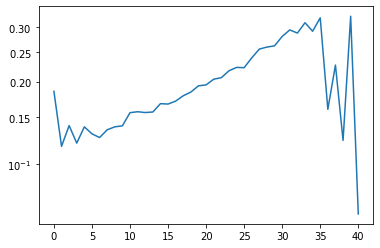

In [72]:
plt.yscale('logit')
plt.plot(df['dti_cat'].index, df['mean_bad_loan'])
plt.show

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original dti measure with two derived measures

In [73]:
df[30:41]

,dti_cat,nrow,mean_bad_loan
30,"(29.0,30.0]",2329,0.280378
31,"(30.0,31.0]",1496,0.293449
32,"(31.0,32.0]",1282,0.287051
33,"(32.0,33.0]",1051,0.308278
34,"(33.0,34.0]",1025,0.290732
35,"(34.0,35.0]",750,0.318667
36,"(35.0,36.0]",75,0.160000
37,"(36.0,37.0]",66,0.227273
38,"(37.0,38.0]",65,0.123077
39,"(38.0,39.0]",59,0.322034


In [0]:
x_train.remove('dti')
x_train.append('dti_core')
x_train.append('dti_delta')

train['dti_core'] = h2o.H2OFrame.ifelse(train['dti'] <= 5, 5, train['dti'])
train['dti_core'] = h2o.H2OFrame.ifelse(train['dti_core'] <= 30, train['dti_core'], 30)

train['dti_delta'] = train['dti'] - train['dti_core']

### 9. Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original delinq_2yrs measure with two derived measures:

In [75]:
train['delinq_2yrs'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,29


In [0]:
breaks = np.linspace(0, 5, 6).tolist()
train['delinq_2yrs_cat'] = train['delinq_2yrs'].cut(breaks=breaks)

In [77]:
mean_target(train, 'delinq_2yrs_cat')

,delinq_2yrs_cat,nrow,mean_bad_loan
0,NaN,0,0.181037
1,"(0.0,1.0]",17158,0.189299
2,"(1.0,2.0]",4635,0.201510
3,"(2.0,3.0]",1488,0.221774
4,"(3.0,4.0]",579,0.215889
5,"(4.0,5.0]",310,0.216129


In [0]:
x_train.remove('delinq_2yrs')
x_train.append('delinq_2yrs_core')
x_train.append('delinq_2yrs_delta')

train['delinq_2yrs_core'] = h2o.H2OFrame.ifelse(train['delinq_2yrs'] <= 3, train['delinq_2yrs'], 3)

train['delinq_2yrs_delta'] = train['delinq_2yrs'] - train['delinq_2yrs_core']

### 10. Separating Typical from Extreme Revolving Credit Line Utilized

In [79]:
train['revol_util'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.7
0.25,35.6
0.5,55.8
0.75,74.2
0.95,92.5
1,150.7


In [0]:
breaks = np.linspace(0, 120, 25).tolist()
train['revol_util_cat'] = train['revol_util'].cut(breaks=breaks)

In [0]:
df = mean_target(train, 'revol_util_cat')

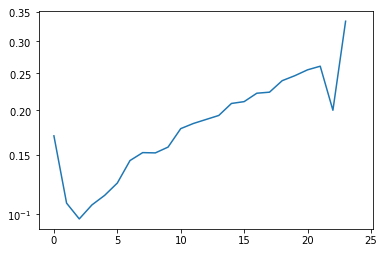

In [82]:
plt.yscale('logit')
plt.plot(df['revol_util_cat'].index, df['mean_bad_loan'])
plt.show()

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original revol_util measure with three derived measures:

In [83]:
df[20:25]

,revol_util_cat,nrow,mean_bad_loan
20,"(95.0,100.0]",4316,0.255097
21,"(100.0,105.0]",238,0.260504
22,"(105.0,110.0]",35,0.200000
23,"(110.0,115.0]",9,0.333333
24,"(115.0,120.0]",3,0.000000


In [0]:
x_train.remove('revol_util')
x_train.append('revol_util_0')
x_train.append('revol_util_core')
x_train.append('revol_util_delta')

train['revol_util_0'] = train['revol_util'] == 0

train['revol_util_core'] = h2o.H2OFrame.ifelse(train['revol_util'] <= 100, train['revol_util'], 100)

train['revol_util_delta'] = train['revol_util'] - train['revol_util_core']

### 11. Separating Typical from Extreme Number of Credit Lines

In [85]:
train['total_acc'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,118


In [0]:
breaks = np.linspace(0, 60, 13).tolist()
train['total_acc_cat'] = train['total_acc'].cut(breaks=breaks)

In [0]:
df = mean_target(train, 'total_acc_cat')

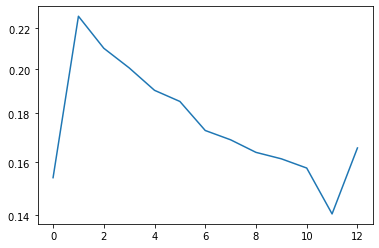

In [88]:
plt.yscale('logit')
plt.plot(df['total_acc_cat'].index, df['mean_bad_loan'])
plt.show()

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original total_acc measure with two derived measures

In [89]:
(train['total_acc'] == None).table()

C1,Count
0,163958
1,29


In [90]:
df[0:3]

,total_acc_cat,nrow,mean_bad_loan
0,NaN,0,0.153788
1,"(0.0,5.0]",2309,0.226072
2,"(5.0,10.0]",12717,0.210034


In [91]:
df[8:13]

,total_acc_cat,nrow,mean_bad_loan
8,"(35.0,40.0]",11251,0.163719
9,"(40.0,45.0]",7174,0.161137
10,"(45.0,50.0]",4203,0.157507
11,"(50.0,55.0]",2350,0.140426
12,"(55.0,60.0]",1287,0.165501


In [0]:
x_train.remove('total_acc')
x_train.append('total_acc_core')
x_train.append('total_acc_delta')

train['total_acc_core'] = h2o.H2OFrame.ifelse(train['total_acc'] <= 50, train['total_acc'], 50)

train['total_acc_delta'] = train['total_acc'] - train['total_acc_core']

### 12. Separating Typical from Extreme Longest Credit Length

In [93]:
train['longest_credit_length'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


In [0]:
breaks = np.linspace(0, 25, 26).tolist()
train['longest_credit_length_cat'] = train['longest_credit_length'].cut(breaks=breaks)

In [0]:
df = mean_target(train, 'longest_credit_length_cat')

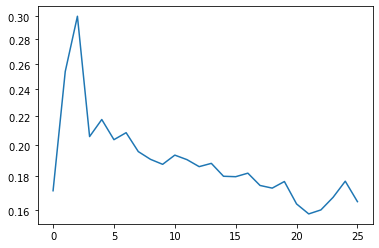

In [96]:
plt.yscale('logit')
plt.plot(df['longest_credit_length_cat'].index, df['mean_bad_loan'])
plt.show()

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original longest_credit_length measure with two derived measures

In [97]:
df[0:4]

,longest_credit_length_cat,nrow,mean_bad_loan
0,NaN,0,0.171094
1,"(0.0,1.0]",67,0.253731
2,"(1.0,2.0]",100,0.300000
3,"(2.0,3.0]",914,0.205689


In [98]:
df[20:26]

,longest_credit_length_cat,nrow,mean_bad_loan
20,"(19.0,20.0]",4682,0.163392
21,"(20.0,21.0]",3892,0.157760
22,"(21.0,22.0]",3350,0.160000
23,"(22.0,23.0]",3092,0.167206
24,"(23.0,24.0]",2856,0.176821
25,"(24.0,25.0]",2471,0.164711


In [0]:
x_train.remove('longest_credit_length')
x_train.append('longest_credit_length_core')
x_train.append('longest_credit_length_delta')

train['longest_credit_length_core'] = h2o.H2OFrame.ifelse(train['longest_credit_length'] <= 3,
                                                          3, train['longest_credit_length'])
train['longest_credit_length_core'] = h2o.H2OFrame.ifelse(train['longest_credit_length_core'] <= 20,
                                                          train['longest_credit_length_core'], 20)

train['longest_credit_length_delta'] = train['longest_credit_length'] - train['longest_credit_length_core']

### 13. Converting Income Verification Status to a 0/1 Indicator
Given that incomes are either verified or not verified, we will create a simplifed verified binary indicator that is 1 when income has been verified

In [100]:
train['verification_status'].table()

verification_status,Count
not verified,59155
verified,104832


In [0]:
x_train.remove('verification_status')
x_train.append('verified')

train['verified'] = train['verification_status'] == 'verified'

In [102]:
train['verified'].table()

verified,Count
0,59155
1,104832


### Saving the Transformed Data to a Known Key
To make it easier to find the data in the cluster, we will assign the transformed dataset to a known key and then retrieving that frame using the get_frame function

In [103]:
print(train.frame_id)

py_205_sid_9199


In [104]:
h2o.assign(train, 'loan_transformed')
train = h2o.get_frame('loan_transformed')
print(train.frame_id)

loan_transformed


In [105]:
print("Response = " + y)
print("Predictors (Orig) = " + str(x_orig))
print("Predictors (Train) = " + str(x_train))

Response = bad_loan
Predictors (Orig) = ['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']
Predictors (Train) = ['emp_length', 'loan_amnt_core', 'loan_amnt_delta', 'term_60months', 'emp_length_missing', 'home_ownership_3cat', 'annual_inc_core', 'annual_inc_delta', 'te_purpose', 'te_addr_state', 'dti_core', 'dti_delta', 'delinq_2yrs_core', 'delinq_2yrs_delta', 'revol_util_0', 'revol_util_core', 'revol_util_delta', 'total_acc_core', 'total_acc_delta', 'longest_credit_length_core', 'longest_credit_length_delta', 'verified']
